### **1. Requirement Gathering**
---

- **Problem:**
    - Melakukan kategori terhadap negara-negara yang diprioritaskan mendapatkan bantuan dari NGO.
- **Business Process:**
    - HELP International akan melakukan funding kepada negara-negara yang membutuhkan. Negara dikategorikan berdasarkan informasi socio-economic, kondisi maupun informasi lainnya mengenai negara tersebut
- **ML Model Type:** Unsupervised Learning
- **Output Type:** Categorical
- **Data Source:** JSON
- **Solution:** Untuk memprediksi apakah negara termasuk negara yang membutuhkan, kita bisa menggunakan beberapa cara
    - **ML Approach:**
        - Baseline model: 
        - Vanilla model: 
        - Multiple Model + Hyperparams
        - Using best model

- **Metrics:** Metrics yang digunakan untuk mengukur performa dari model ML yang dibuat akan menggunakan **Silhouette Score**

## **2. Data Pipeline**
---

In [321]:
import joblib
import yaml

In [322]:
def dump_joblib(data, path: str) -> None:
    joblib.dump(data, path)


def load_joblib(path: str):
    return joblib.load(path)

In [323]:
def load_params(param_dir):
    with open(param_dir, 'r') as file:
        params = yaml.safe_load(file)

    return params

In [324]:
params = load_params(param_dir = "config/params.yaml")

params

{'dataset_filename': 'country_data.csv',
 'dataset_dump_path': {'raw': 'data/raw/',
  'interim': 'data/interim/',
  'processed': 'data/processed/'},
 'int64_columns': ['income', 'gdpp'],
 'float64_columns': ['child_mort',
  'exports',
  'health',
  'imports',
  'inflation',
  'life_expec',
  'total_fer'],
 'object_columns': ['country'],
 'features': ['country',
  'child_mort',
  'exports',
  'health',
  'imports',
  'income',
  'inflation',
  'life_expec',
  'total_fer',
  'gdpp'],
 'model_dump_path': 'models/'}

In [325]:
import json
from sqlalchemy import create_engine, text as sql_text
from dotenv import load_dotenv
import os
import pandas as pd
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

load_dotenv()

False

#### **2.1 Data Ingestion**
---

In [326]:
file_path = 'country_data.json'

with open(file_path, 'r') as file:
    json_data = json.load(file)

df_country = pd.json_normalize(json_data['country_data'])

In [327]:
df_country

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


In [328]:
dump_joblib(data = df_country, path = params["dataset_dump_path"]["raw"] + "raw_data.pkl")

#### **2.2 Data Definition**
---

- `country`: Name of the country
- `child_mort`: Death of children under 5 years of age per 1000 live births
- `exports`: Exports of goods and services per capita, given as a percentage of the GDP per capita
- `health`: Total health spending per capita, given as a percentage of the GDP per capita
- `imports`: Imports of goods and services per capita, given as a percentage of the GDP per capita
- `income`: Net income per person
- `inflation`: The measurement of the annual growth rate of the Total GDP
- `life_expec`: The average number of years a newborn child would live if the current mortality patterns remain the same
- `total_fer`: The number of children that would be born to each woman if the current age-fertility rates remain the same
- `gdpp`: The GDP per capita, calculated as the Total GDP divided by the total population

#### **2.3 Data Validation**
---

- Check data type
- Check data shape
- Check data distribution
- Check missing values

**Check Data Type**

In [329]:
df_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


**Check Data Shape**

In [330]:
print(f"Country Data have {df_country.shape[0]} rows and {df_country.shape[1]} columns")

Country Data have 167 rows and 10 columns


**Check Data Distribution**

In [331]:
df_country.describe().T

,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.270060,40.328931,2.6000,8.250,19.30,62.10,208.00
exports,167.0,41.108976,27.412010,0.1090,23.800,35.00,51.35,200.00
health,167.0,6.815689,2.746837,1.8100,4.920,6.32,8.60,17.90
imports,167.0,46.890215,24.209589,0.0659,30.200,43.30,58.75,174.00
income,167.0,17144.688623,19278.067698,609.0000,3355.000,9960.00,22800.00,125000.00
inflation,167.0,7.781832,10.570704,-4.2100,1.810,5.39,10.75,104.00
life_expec,167.0,70.555689,8.893172,32.1000,65.300,73.10,76.80,82.80
total_fer,167.0,2.947964,1.513848,1.1500,1.795,2.41,3.88,7.49
gdpp,167.0,12964.155689,18328.704809,231.0000,1330.000,4660.00,14050.00,105000.00


**Check Missing Values**

In [332]:
df_country.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

There are no missing values

**Check Duplicactes**

In [333]:
df_country.duplicated().sum()

0

and no duplicates

#### **2.4 Data Defense**
---

In [334]:
def data_defense_checker(input_data: pd.DataFrame, params: dict) -> None:
    try:
        print("===== Start Data Defense Checker =====")
        # check data types
        assert input_data[params["features"]].select_dtypes("object").columns.to_list() == params["object_columns"], "an error occurs in object columns"
        assert input_data[params["features"]].select_dtypes("int").columns.to_list() == params["int64_columns"], "an error occurs in integer columns"
        assert input_data[params["features"]].select_dtypes("float").columns.to_list() == params["float64_columns"], "an error occurs in integer columns"

    except Exception:
        raise Exception("Failed Data Defense Checker")

    finally:
        print("===== Finish Data Defense Checker =====")

In [335]:
data_defense_checker(input_data = df_country,
                     params = params)

===== Start Data Defense Checker =====
===== Finish Data Defense Checker =====


## **3. EDA (Exploratory Data Analysis)**
---

Text(0, 0.5, 'Density')

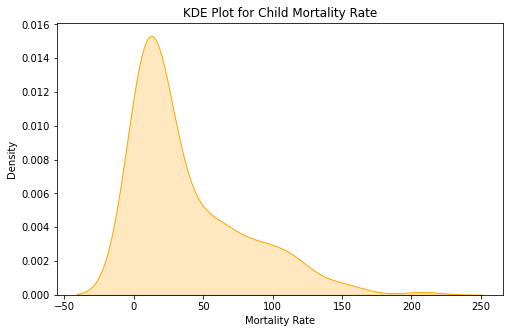

In [336]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df_country['child_mort'], shade=True, color='orange')
plt.title('KDE Plot for Child Mortality Rate')
plt.xlabel('Mortality Rate')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

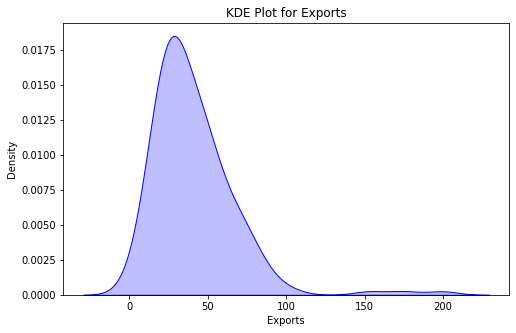

In [338]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df_country['exports'], shade=True, color='blue')
plt.title('KDE Plot for Exports')
plt.xlabel('Exports')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

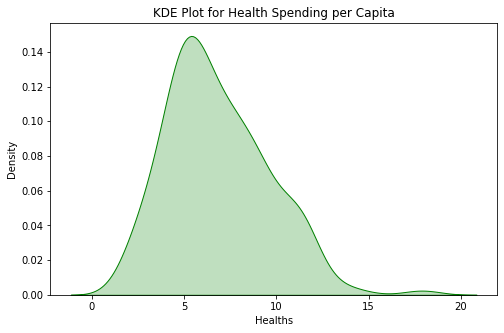

In [339]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df_country['health'], shade=True, color='green')
plt.title('KDE Plot for Health Spending per Capita')
plt.xlabel('Healths')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

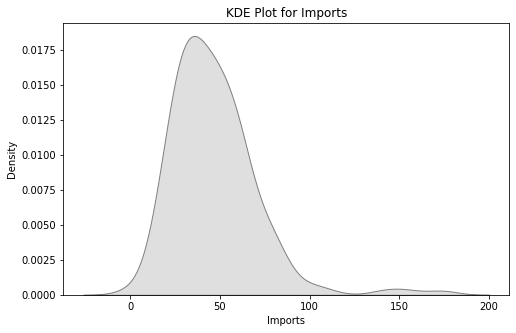

In [340]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df_country['imports'], shade=True, color='gray')
plt.title('KDE Plot for Imports')
plt.xlabel('Imports')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

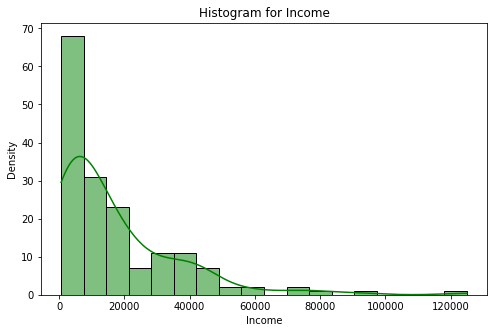

In [341]:
plt.figure(figsize=(8, 5))
sns.histplot(df_country['income'], kde=True, color='green')
plt.title('Histogram for Income')
plt.xlabel('Income')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

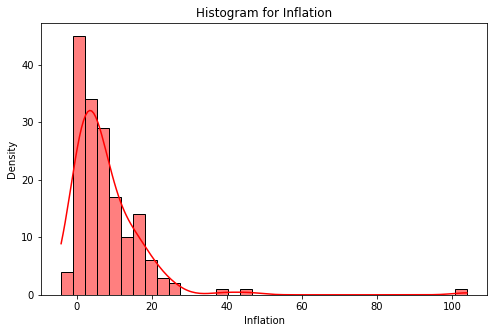

In [342]:
plt.figure(figsize=(8, 5))
sns.histplot(df_country['inflation'], kde=True, color='red')
plt.title('Histogram for Inflation')
plt.xlabel('Inflation')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

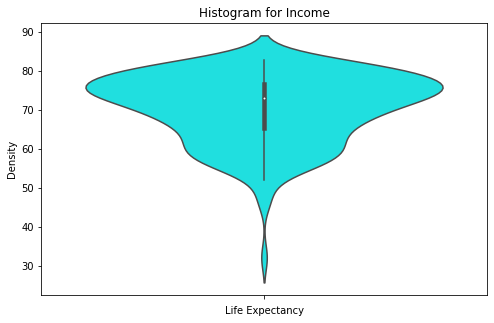

In [343]:
plt.figure(figsize=(8, 5))
sns.violinplot(y = df_country['life_expec'], color='cyan')
plt.title('Histogram for Income')
plt.xlabel('Life Expectancy')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

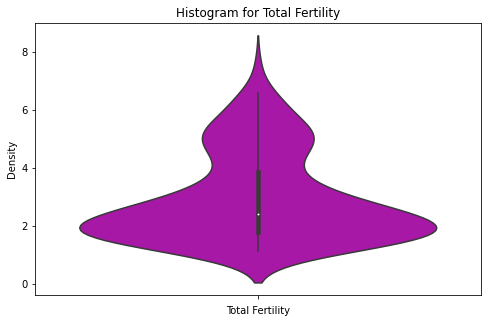

In [344]:
plt.figure(figsize=(8, 5))
sns.violinplot(y=df_country['total_fer'], kde=True, color='m')
plt.title('Histogram for Total Fertility')
plt.xlabel('Total Fertility')
plt.ylabel('Density')

Text(0.5, 0, 'GDPP')

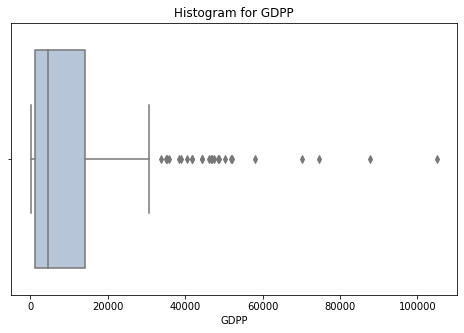

In [345]:
plt.figure(figsize=(8, 5))
sns.boxplot(df_country['gdpp'], color='lightsteelblue')
plt.title('Histogram for GDPP')
plt.xlabel('GDPP')

<AxesSubplot:xlabel='income', ylabel='life_expec'>

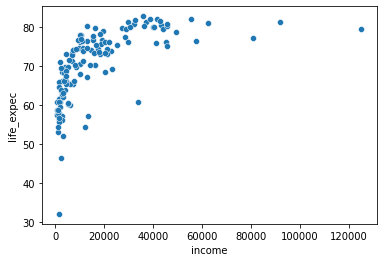

In [346]:
sns.scatterplot(x=df_country['income'], y=X_train['life_expec'])

<AxesSubplot:>

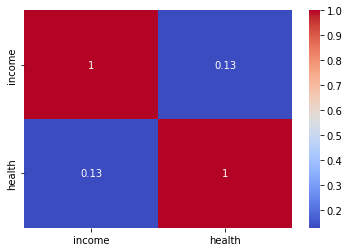

In [347]:
income_gdpp_corr = df_country[['income', 'health']].corr()
sns.heatmap(income_gdpp_corr, annot=True, cmap='coolwarm')

<AxesSubplot:xlabel='income', ylabel='gdpp'>

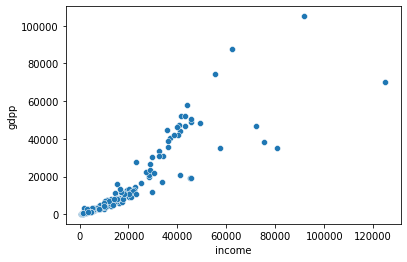

In [485]:
sns.scatterplot(x=df_country['income'], y=df_country['gdpp'])

<AxesSubplot:xlabel='income', ylabel='health'>

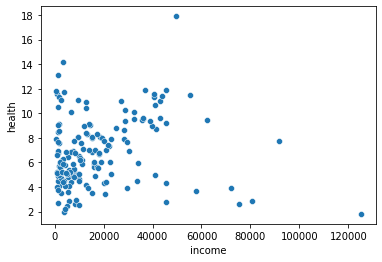

In [486]:
sns.scatterplot(x=df_country['income'], y=df_country['health'])

<AxesSubplot:xlabel='gdpp', ylabel='inflation'>

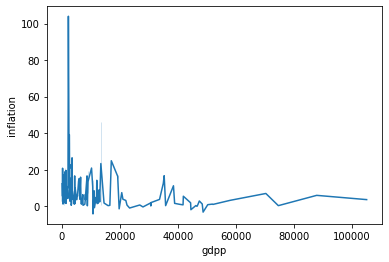

In [350]:
sns.lineplot(x='gdpp', y='inflation', data=df_country)

In [351]:
import plotly.express as px 

fig = px.scatter(df_country, x="income", y="life_expec", 
                 size='child_mort',
                 color='child_mort')
  
fig.show()

In [487]:
import plotly.express as px 

fig = px.scatter(df_country, x="income", y="life_expec", 
                 size='total_fer',
                 color='total_fer')
  
fig.show()

## **4. Preprocessing & Feature Engineering**
---

### **4.1 Standardization and Normalization**

In [557]:
import numpy as np

df_transformed = df_country.copy()

df_transformed['log_income'] = np.log1p(df_transformed['income'])
df_transformed = df_transformed.drop(['income', 'exports', 'imports', 'inflation'], axis='columns')
df_transformed

,country,child_mort,health,life_expec,total_fer,gdpp,log_income
0,Afghanistan,90.2,7.58,56.2,5.82,553,7.384610
1,Albania,16.6,6.55,76.3,1.65,4090,9.203416
2,Algeria,27.3,4.17,76.5,2.89,4460,9.465060
3,Angola,119.0,2.85,60.1,6.16,3530,8.682877
4,Antigua and Barbuda,10.3,6.03,76.8,2.13,12200,9.857496
...,...,...,...,...,...,...,...
162,Vanuatu,29.2,5.25,63.0,3.50,2970,7.989899
163,Venezuela,17.1,4.91,75.4,2.47,13500,9.711176
164,Vietnam,23.3,6.84,73.1,1.95,1310,8.409831
165,Yemen,56.3,5.18,67.5,4.67,1310,8.407602


In [565]:
features = [col for col in df_transformed.columns if col != 'country']
features_T = [f"{col}_T" for col in features]

In [566]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

min_max_scaler = MinMaxScaler()
df_transformed[features_T] = min_max_scaler.fit_transform(df_transformed[features])

df_transformed

,country,child_mort,health,life_expec,total_fer,gdpp,log_income,child_mort_T,health_T,life_expec_T,total_fer_T,gdpp_T,log_income_T
0,Afghanistan,90.2,7.58,56.2,5.82,553,7.384610,0.426485,0.358608,0.475345,0.736593,0.003073,0.182457
1,Albania,16.6,6.55,76.3,1.65,4090,9.203416,0.068160,0.294593,0.871795,0.078864,0.036833,0.524170
2,Algeria,27.3,4.17,76.5,2.89,4460,9.465060,0.120253,0.146675,0.875740,0.274448,0.040365,0.573327
3,Angola,119.0,2.85,60.1,6.16,3530,8.682877,0.566699,0.064636,0.552268,0.790221,0.031488,0.426373
4,Antigua and Barbuda,10.3,6.03,76.8,2.13,12200,9.857496,0.037488,0.262275,0.881657,0.154574,0.114242,0.647057
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,5.25,63.0,3.50,2970,7.989899,0.129503,0.213797,0.609467,0.370662,0.026143,0.296178
163,Venezuela,17.1,4.91,75.4,2.47,13500,9.711176,0.070594,0.192666,0.854043,0.208202,0.126650,0.619567
164,Vietnam,23.3,6.84,73.1,1.95,1310,8.409831,0.100779,0.312617,0.808679,0.126183,0.010299,0.375073
165,Yemen,56.3,5.18,67.5,4.67,1310,8.407602,0.261441,0.209447,0.698225,0.555205,0.010299,0.374654


In [567]:
from sklearn.cluster import KMeans

def k_means_optimize(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    fig = plt.subplots(figsize=(10, 5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

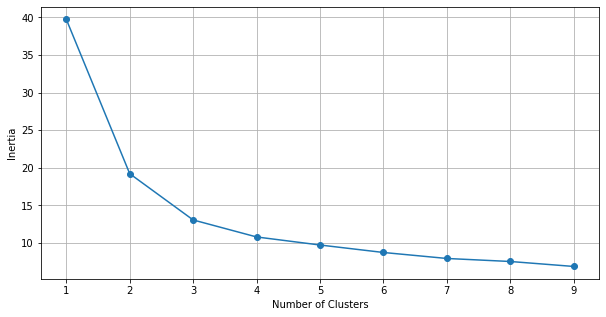

In [568]:
k_means_optimize(df_transformed[features_T], 10)

2 0.456046689484423
3 0.3968750298663942
4 0.32690667086540254
5 0.33633586597982024
6 0.31479359145235
7 0.2679157341139131
8 0.27789787363587065


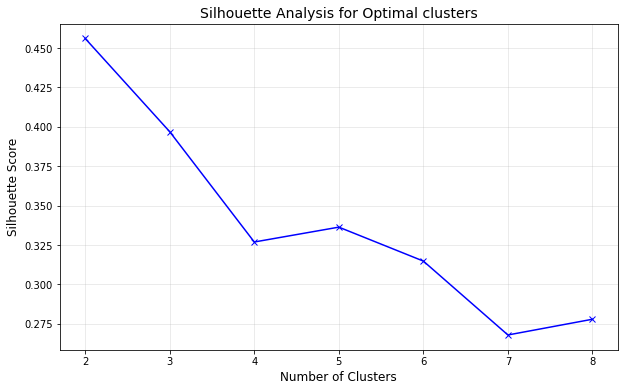

In [569]:
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(df_transformed[features_T])
    cluster_labels = kmeans.labels_

    silhouette_avg.append(silhouette_score(df_transformed[features_T], cluster_labels))

for i in range(len(range_n_clusters)):
    print(range_n_clusters[i], silhouette_avg[i])

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg, "bx-")
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.title("Silhouette Analysis for Optimal clusters", fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

In [289]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# df_pca = pca.fit_transform(df_scaled[features_T])
# df_pca = pd.DataFrame(df_pca)
# df_pca

,0,1
0,-2.913025,0.095621
1,0.429911,-0.588156
2,-0.285225,-0.455174
3,-2.932423,1.695555
4,1.033576,0.136659
...,...,...
162,-0.820631,0.639570
163,-0.551036,-1.233886
164,0.498524,1.390744
165,-1.887451,-0.109453


### **4.2 KMeans Clustering**
---

In [294]:
from sklearn.cluster import KMeans

def k_means_optimize(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    fig = plt.subplots(figsize=(10, 5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()


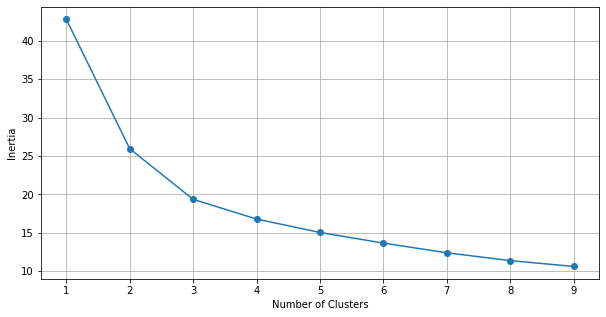

In [295]:
k_means_optimize(df_scaled[features_T], 10)

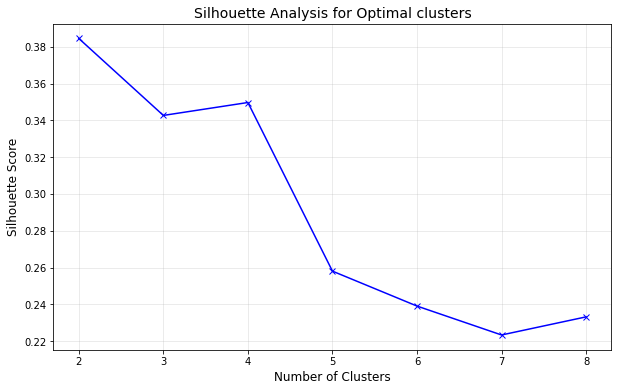

In [296]:
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(df_scaled[features_T])
    cluster_labels = kmeans.labels_

    silhouette_avg.append(silhouette_score(df_scaled[features_T], cluster_labels))

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg, "bx-")
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.title("Silhouette Analysis for Optimal clusters", fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

In [297]:
kmeans = KMeans(n_clusters=4)

In [298]:
kmeans.fit(df_scaled[features_T])

KMeans(n_clusters=4)

In [299]:
df_scaled['cluster'] = kmeans.labels_
df_scaled['cluster'] = df_scaled['cluster'] + 1

In [300]:
df_scaled

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,...,child_mort_T,exports_T,health_T,imports_T,income_T,inflation_T,life_expec_T,total_fer_T,gdpp_T,cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,...,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073,2
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,...,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833,3
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,...,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365,3
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,...,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488,2
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,...,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,...,0.129503,0.232582,0.213797,0.302609,0.018820,0.063118,0.609467,0.370662,0.026143,3
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,...,0.070594,0.142032,0.192666,0.100809,0.127750,0.463081,0.854043,0.208202,0.126650,3
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,...,0.100779,0.359651,0.312617,0.460715,0.031200,0.150725,0.808679,0.126183,0.010299,3
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,...,0.261441,0.149536,0.209447,0.197397,0.031120,0.257000,0.698225,0.555205,0.010299,2


In [301]:
country_with_categories = df_scaled.sort_values(by='cluster')
country_with_categories

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,...,child_mort_T,exports_T,health_T,imports_T,income_T,inflation_T,life_expec_T,total_fer_T,gdpp_T,cluster
29,Canada,5.6,29.1,11.30,31.0,40700,2.870,81.3,1.63,47400,...,0.014606,0.145034,0.589807,0.177850,0.322298,0.065428,0.970414,0.075710,0.450219,1
23,Brunei,10.5,67.4,2.84,28.0,80600,16.700,77.1,1.84,35300,...,0.038462,0.336638,0.064015,0.160602,0.643061,0.193235,0.887574,0.108833,0.334727,1
114,Norway,3.2,39.7,9.48,28.5,62300,5.950,81.0,1.95,87800,...,0.002921,0.198063,0.476694,0.163476,0.495944,0.093892,0.964497,0.126183,0.835829,1
111,New Zealand,6.2,30.3,10.10,28.0,32300,3.730,80.9,2.17,33700,...,0.017527,0.151037,0.515227,0.160602,0.254769,0.073376,0.962525,0.160883,0.319455,1
60,Greece,3.9,22.1,10.30,30.7,28700,0.673,80.4,1.48,26900,...,0.006329,0.110015,0.527657,0.176125,0.225828,0.045125,0.952663,0.052050,0.254550,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,"Macedonia, FYR",10.4,39.8,7.09,58.1,11400,2.040,74.0,1.47,4540,...,0.037975,0.198563,0.328154,0.333656,0.086751,0.057758,0.826430,0.050473,0.041129,3
101,"Micronesia, Fed. Sts.",40.0,23.5,14.20,81.0,3340,3.800,65.4,3.46,2860,...,0.182084,0.117019,0.770044,0.465315,0.021955,0.074023,0.656805,0.364353,0.025093,3
133,Singapore,2.8,200.0,3.96,174.0,72100,-0.046,82.7,1.15,46600,...,0.000974,1.000000,0.133623,1.000000,0.574728,0.038481,0.998028,0.000000,0.442583,4
98,Malta,6.8,153.0,8.65,154.0,28300,3.830,80.3,1.36,21100,...,0.020448,0.764872,0.425109,0.885014,0.222613,0.074300,0.950690,0.033123,0.199191,4


### **4.3 DBScan**
---

In [315]:
from sklearn.cluster import DBSCAN

db = DBSCAN().fit(df_scaled[features_T])
db 

DBSCAN()

In [316]:
db.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int64)

In [317]:
silhouette_score(df_scaled[features_T], db.labels_)

0.4993958842751086